In [1]:
#!pip install -q sciunit==0.2.3

In [2]:
import sciunit
import numpy as np

import os
import json
import matplotlib
# To avoid figures being plotted on screen (we wish to save to file directly)
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Load the Observation data

In [3]:
def format_observation(observation_path=None):
        
    #self.observation_path = observation_path
    #self.observation_key = observation_key

    load_data=m.load(observation_path)
    observation_key = list(load_data.keys())[0]
    observation = {observation_key: np.array(load_data[observation_key])}
   
    return observation

In [4]:
# observation=format_observation(observation_path='')

In [5]:
# observation_key = list(observation.keys())[0]
# plt.plot(observation[observation_key])

# Define the Model capability

In [6]:
class cap_generates_spikeraster(sciunit.Capability):
    """Indicates that the model has a spike raster as output. """
    
    def model_prediction(self):
        ...
        raise NotImplementedError()
       
    def get_spikeraster(self):
        """This function is called by the test, and then the model_prediction function"""            
        spikeraster = self.spikeraster
        return spikeraster

# Define the Model class

In [7]:
class BezaireSoltesz_CA1model(sciunit.Model,cap_generates_spikeraster):
    
    def __init__(self, model_path = '../modeldbca1', results_dir='results', run_dir=None):
        sciunit.Model.__init__(self, name = "BezaireSoltesz_CA1model")
        
        self.results_dir = os.path.join(model_path, results_dir)
        self.result_path = os.path.join(model_path, results_dir, run_dir)
        
        self.result_figs = os.path.join(model_path, results_dir, "figures", "Sasaki_experiment")
        if not os.path.exists(self.result_figs):
            os.makedirs(self.result_figs)

    def read_model_result(self, file_name):
        file_path = os.path.join(self.result_path, file_name)
        with open(file_path, 'r') as fp:
            mod_data = np.genfromtxt(fp)
        return mod_data    
        
    def model_prediction(self):
        return self.spikeraster

In [8]:
import math
from math import floor

cell_types = [ "ca3cell", "pyramidalcell", "cckcell", "scacell", "axoaxoniccell", \
              "bistratifiedcell", "ivycell", "ngfcell", "olmcell", "pvbasketcell" ]
num_cellTypes = len(cell_types)

In [10]:
Duration=20  # Biological time to be simulated, in ms
Scale=110
# StimType="SpikesTrainSingleSpike"
# StimType="SpikesTrainVaryingFreqPosition"
StimType="Spikes4TrainVaryingFreqPosition"
# StimType="SpikesTrainVaryingFreq"
j=53; i=0;
run_dir = os.path.join(StimType, f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}')
model = BezaireSoltesz_CA1model(run_dir = run_dir)
cellType = "pyramidalcell"
neuron_slice_data = model.read_model_result(f'neuron_{cellType}_slice_ids.dat')
SlicesNum = 1 + int(max(neuron_slice_data[:,1]))

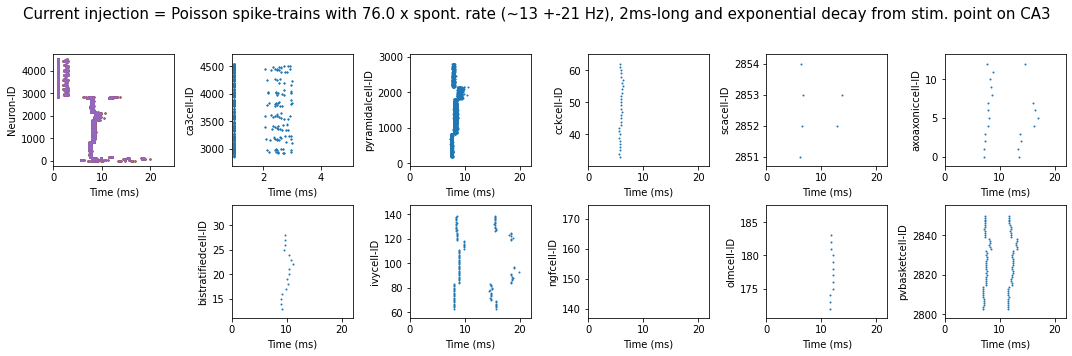

In [11]:
# %matplotlib agg
plt.close('all')

ncols = 5
for j in range(76,77):
    for i in range(0,1):
        if j < 10:
            dir_name = f'Scale_{Scale}_{StimType}_000{j}_{i}_SimDuration_{Duration}'
        elif (j >=10 and j < 100):
            dir_name = f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}'
        else:
            dir_name = f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}'
            
        run_dir =  os.path.join(StimType, dir_name)
        model = BezaireSoltesz_CA1model(run_dir = run_dir)
       
        spikeraster_data = model.read_model_result('spikeraster.dat')

        fig, ax = plt.subplots(2, ncols+1, figsize=(15,5))        
        for type_i, cellType in enumerate(cell_types):
            row_fig = floor(type_i/ncols)
            if row_fig != 0:
                ax[row_fig, 0].set_axis_off()
            else:
                ax[row_fig, 0].plot(spikeraster_data[:,0], spikeraster_data[:,1], 'o', markersize=1)
                ax[row_fig, 0].set(ylabel='Neuron-ID', xlabel ='Time (ms)', xlim = [0,Duration+5])
            
            neuron_slice_data = model.read_model_result(f'neuron_{cellType}_slice_ids.dat')
            min_ID = min(neuron_slice_data[:,0]); max_ID = max(neuron_slice_data[:,0])
            min_ID = min_ID - (max_ID - min_ID)/10; max_ID = max_ID + (max_ID - min_ID)/10;
            
            # Filtering out the cellType neurons from the spikeraster data
            neuron_spikes_inds = np.in1d(spikeraster_data[:,1], neuron_slice_data[:,0])
            ax[row_fig, 1+type_i%ncols].plot(spikeraster_data[neuron_spikes_inds,0], spikeraster_data[neuron_spikes_inds,1], 'o', markersize=1)
            ax[row_fig, 1+type_i%ncols].set(ylabel=f'{cellType}-ID', xlabel ='Time (ms)', ylim = [min_ID, max_ID], xlim = [0.9,5.1])
            if cellType is not "ca3cell":
                ax[row_fig, 1+type_i%ncols].set(xlim = [0,1.10*Duration])

        # fig.suptitle(f'Current injection = A synchronous single-spike on {j}.{i} % randomly picked CA3-SCs', fontsize=15)
        # fig.suptitle(f'Current injection = Poisson spike-trains with {j}.{i} x spont. rate (~13 +-21 Hz) and 2ms-long, on 5 % randomly picked CA3-SCs', fontsize=15)
        fig.suptitle(f'Current injection = Poisson spike-trains with {j}.{i} x spont. rate (~13 +-21 Hz), 2ms-long and exponential decay from stim. point on CA3', fontsize=15)            
        fig.tight_layout()
        fig.subplots_adjust(top=0.85)
 
        if j < 10:
            fig_name = f'Scale_{Scale}_{StimType}_000{j}_{i}_SimDuration_{Duration}_all_rasters.png'
        elif (j >=10 and j < 100):
            fig_name = f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}_all_rasters.png'
        else:
            fig_name = f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}_all_rasters.png'

        fig_path = os.path.join(model.result_figs, StimType, f'Scale_{Scale}_SimDuration_{Duration}_all_rasters', fig_name)
        # fig.savefig(fig_path)
        
        del run_dir, model, spikeraster_data, neuron_slice_data, neuron_spikes_inds

In [ ]:
# %matplotlib agg
plt.close('all')

ncols=5
for j in range(93,96):
    for i in range(0,1):
        if j < 10:
            dir_name = f'Scale_{Scale}_{StimType}_000{j}_{i}_SimDuration_{Duration}'
        elif (j >=10 and j < 100):
            dir_name = f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}'
        else:
            dir_name = f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}'
            
        run_dir =  os.path.join(StimType, dir_name)
        model = BezaireSoltesz_CA1model(run_dir = run_dir)
       
        spikeraster_data = model.read_model_result('spikeraster.dat')

        fig, ax = plt.subplots(2, ncols+1, figsize=(15,5))        
        for type_i, cellType in enumerate(cell_types):
            row_fig = floor(type_i/ncols)
            if row_fig != 0:
                ax[row_fig, 0].set_axis_off()
            else:
                ax[row_fig, 0].plot(spikeraster_data[:,0], spikeraster_data[:,1], 'o', markersize=1)
                ax[row_fig, 0].set(ylabel='Neuron-ID', xlabel ='Time (ms)', xlim = [0,Duration+5])
            
            neuron_slice_data = model.read_model_result(f'neuron_{cellType}_slice_ids.dat')

            min_ID = min(neuron_slice_data[:,0]); max_ID = max(neuron_slice_data[:,0])
            min_ID = min_ID - (max_ID - min_ID)/10; max_ID = max_ID + (max_ID - min_ID)/10;            
            
            # Filtering out the cellType neurons from the slicing data
            neuron_spikes_inds = np.in1d(spikeraster_data[:,1], neuron_slice_data[:,0])
            neuron_slices_inds = np.in1d(neuron_slice_data[:,0], spikeraster_data[neuron_spikes_inds,1])
            ax[row_fig, 1+type_i%ncols].plot(1+neuron_slice_data[neuron_slices_inds,1], neuron_slice_data[neuron_slices_inds,0], 'o', markersize=1)
            ax[row_fig, 1+type_i%ncols].set(ylabel=f'{cellType}-ID', xlabel='Slice', xlim=[0, SlicesNum], ylim = [min_ID, max_ID], xticks =range(1,10))

        # fig.suptitle(f'Current injection = A synchronous single-spike on {j}.{i} % randomly picked CA3-SCs', fontsize=15)
        # fig.suptitle(f'Current injection = Poisson spike-trains with {j}.{i} x spont. rate (~13 +-21 Hz) and 2ms-long, on 5 % randomly picked CA3-SCs', fontsize=15)
        fig.suptitle(f'Current injection = Poisson spike-trains with {j}.{i} x spont. rate (~13 +-21 Hz), 2ms-long and exponential decay from stim. point on CA3', fontsize=15)            

        fig.tight_layout()
        fig.subplots_adjust(top=0.90)
 
        if j < 10:
            fig_name = f'Scale_{Scale}_{StimType}_000{j}_{i}_SimDuration_{Duration}_all_slices.png'
        elif (j >=10 and j < 100):
            fig_name = f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}_all_slices.png'
        else:
            fig_name = f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}_all_slices.png'
 

        fig_path = os.path.join(model.result_figs, StimType, f'Scale_{Scale}_SimDuration_{Duration}_all_slices', fig_name)
        # fig.savefig(fig_path)
        
        del run_dir, model, spikeraster_data, neuron_slice_data, neuron_spikes_inds

In [13]:
# %matplotlib agg

j=53; i=0;
run_dir =  os.path.join(StimType, f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}')
model = BezaireSoltesz_CA1model(run_dir = run_dir)

cellType_UnderStudy = cell_types[1]
neuron_slice_data = model.read_model_result(f'neuron_{cellType_UnderStudy}_slice_ids.dat')
cells_monitored_IDs = []
for slice in range(0,SlicesNum):
    cells_slice_inds = np.in1d(neuron_slice_data[:,1], [slice])
    cells_slice = neuron_slice_data[cells_slice_inds,0]
    cells_monitored_IDs.append(np.random.choice(cells_slice, size=101, replace=False))

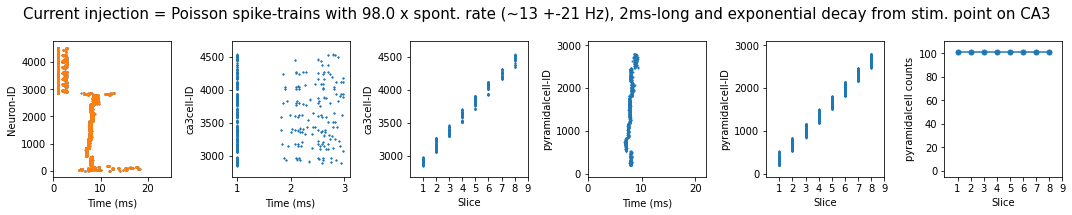

In [17]:
# %matplotlib agg

plt.close('all')

cell_types = ["ca3cell", cellType_UnderStudy]
ncols=5
for j in range(98,99):
    for i in range(0,1):

        if j < 10:
            dir_name = f'Scale_{Scale}_{StimType}_000{j}_{i}_SimDuration_{Duration}'
        elif (j >=10 and j < 100):
            dir_name = f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}'
        else:
            dir_name = f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}'

        run_dir =  os.path.join(StimType, dir_name)        
        model = BezaireSoltesz_CA1model(run_dir = run_dir)
       
        spikeraster_data = model.read_model_result('spikeraster.dat')

        fig, ax = plt.subplots(1, ncols+1, figsize=(15,3))        
        for type_i, cellType in enumerate(cell_types):
            
            ax[0].plot(spikeraster_data[:,0], spikeraster_data[:,1], 'o', markersize=1)
            ax[0].set(ylabel='Neuron-ID', xlabel ='Time (ms)', xlim = [0,Duration+5])
            
            neuron_slice_data = model.read_model_result(f'neuron_{cellType}_slice_ids.dat')
            min_ID = min(neuron_slice_data[:,0]); max_ID = max(neuron_slice_data[:,0])
            min_ID = min_ID - (max_ID - min_ID)/10; max_ID = max_ID + (max_ID - min_ID)/10;            
 
            if cellType is not cellType_UnderStudy:
                cells_IDs = neuron_slice_data[:,0]
            else:
                cells_IDs = cells_monitored_IDs

            # Filtering out the cellType neurons from the spikeraster data
            neuron_spikes_inds = np.in1d(spikeraster_data[:,1], cells_IDs)
            ax[1+2*(type_i%2)].plot(spikeraster_data[neuron_spikes_inds,0], spikeraster_data[neuron_spikes_inds,1], 'o', markersize=1)
            ax[1+2*(type_i%2)].set(ylabel=f'{cellType}-ID', xlabel ='Time (ms)', xlim = [0.9,3.1], ylim = [min_ID, max_ID] )
            if cellType is not "ca3cell":
                ax[1+2*(type_i%2)].set(xlim = [0,1.10*Duration])
                
            # Filtering out the cellType neurons from the slicing data 
            neuron_slices_inds = np.in1d(neuron_slice_data[:,0], spikeraster_data[neuron_spikes_inds,1])
            ax[2+2*(type_i%2)].plot(1+neuron_slice_data[neuron_slices_inds,1], neuron_slice_data[neuron_slices_inds,0], 'o', markersize=1)
            ax[2+2*(type_i%2)].set(ylabel=f'{cellType}-ID', xlabel='Slice', xlim=[0, SlicesNum], ylim = [min_ID, max_ID], xticks =range(1,10))
            
            if cellType is cellType_UnderStudy:
                slices_act, cells_act = np.unique(neuron_slice_data[neuron_slices_inds,1], return_counts=True)  
                all_slices = np.arange(0, 1 + int(max(neuron_slice_data[:,1]) ))    
                cell_counts = np.zeros(len(all_slices))
                cell_counts[slices_act.astype(int)] = cells_act
                ax[3+2*(type_i%2)].plot(1+all_slices, cell_counts, '-o', markersize=5)
                ax[3+2*(type_i%2)].set(ylabel=f'{cellType} counts', xlabel='Slice', xlim=[0, SlicesNum],  xticks =range(1,10), ylim=[-5, 110])

        # fig.suptitle(f'Current injection = A synchronous single-spike on {j}.{i} % randomly picked CA3-SCs', fontsize=15)
        # fig.suptitle(f'Current injection = Poisson spike-trains with {j}.{i} x spont. rate (~13 +-21 Hz) and 2ms-long, on 5 % randomly picked CA3-SCs', fontsize=15)    
        fig.suptitle(f'Current injection = Poisson spike-trains with {j}.{i} x spont. rate (~13 +-21 Hz), 2ms-long and exponential decay from stim. point on CA3', fontsize=15)            

        fig.tight_layout()
        fig.subplots_adjust(top=0.82)

        if j < 10:
            fig_name = f'Scale_{Scale}_{StimType}_000{j}_{i}_SimDuration_{Duration}_all_{cellType_UnderStudy}.png'
        elif (j >=10 and j < 100):
            fig_name = f'Scale_{Scale}_{StimType}_00{j}_{i}_SimDuration_{Duration}_all_{cellType_UnderStudy}.png'
        else:
            fig_name = f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}_all_{cellType_UnderStudy}.png'
            
        fig_path = os.path.join(model.result_figs, StimType, f'Scale_{Scale}_SimDuration_{Duration}_all_{cellType_UnderStudy}', fig_name)
        # fig.savefig(fig_path)
        del run_dir, model, spikeraster_data, neuron_slice_data, neuron_spikes_inds

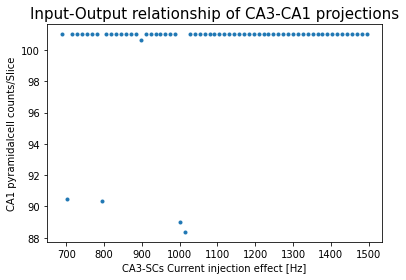

In [15]:
plt.close('all')

cell_types = [ cellType_UnderStudy ]
cell_act_mean = []; current_amp = [];

model_path = '../modeldbca1'; results_dir='results'
resultStimType_path=os.path.join(model_path, results_dir, StimType)
results_dirs = os.listdir(resultStimType_path)

for results_dir in results_dirs:
    run_dir = os.path.join(StimType, results_dir)
    str = os.path.split(results_dir)[-1]

    model = BezaireSoltesz_CA1model(run_dir = run_dir)
    spikeraster_data = model.read_model_result('spikeraster.dat')

    for type_i, cellType in enumerate(cell_types):
        neuron_slice_data = model.read_model_result(f'neuron_{cellType}_slice_ids.dat')

        cells_IDs = cells_monitored_IDs

        # Filtering out the cellType neurons from the spikeraster data
        neuron_spikes_inds = np.in1d(spikeraster_data[:,1], cells_IDs)

        # Filtering out the cellType neurons from the slicing data 
        neuron_slices_inds = np.in1d(neuron_slice_data[:,0], spikeraster_data[neuron_spikes_inds,1])

        slices_act, cells_act = np.unique(neuron_slice_data[neuron_slices_inds,1], return_counts=True)  
        all_slices = np.arange(0, SlicesNum)   
        cell_counts = np.zeros(len(all_slices))
        cell_counts[slices_act.astype(int)] = cells_act

        cell_act_mean.append(cell_counts.mean())

        j = int(str.split('_')[-4]); i = int(str.split('_')[-3])
        # current_amp.append(j+i/10) # For StimType = SpikesTrainSingleSpike
        current_amp.append((j+i/10)*13) # For StimType = SpikesTrainVaryingFreq or SpikesTrainVaryingFreqPosition
        
        del neuron_slice_data, cells_IDs, neuron_spikes_inds, neuron_slices_inds

    del run_dir, model, spikeraster_data

      
fig = plt.plot(current_amp, cell_act_mean, 'o', markersize=3)
# plt.xlabel('CA3-SCs Current injection effect [%]'); plt.ylabel(f'CA1 {cellType} counts/Slice')
plt.xlabel('CA3-SCs Current injection effect [Hz]'); plt.ylabel(f'CA1 {cellType} counts/Slice')
plt.title('Input-Output relationship of CA3-CA1 projections', fontsize=15)

run_dir =  os.path.join(StimType, f'Scale_{Scale}_{StimType}_0{j}_{i}_SimDuration_{Duration}')
model = BezaireSoltesz_CA1model(run_dir = run_dir)

fig_name = f'Scale_{Scale}_{StimType}_SimDuration_{Duration}_IO_{cellType_UnderStudy}.png'
fig_path = os.path.join(model.result_figs, StimType, fig_name)

fig_path = os.path.join(model.result_figs, StimType, fig_name)
# plt.savefig(fig_path)

# Define the Score

In [ ]:
import sciunit.utils as utils
import quantities as pq

from scipy.stats import power_divergence
from collections import namedtuple

NeymanResult = namedtuple('NeymanResult', ('statistic_n', 'pvalue'))
class NeymanScore(sciunit.Score):
    """
    A Neyman score. A float giving the result of
    a Neyman goodness-of-fit test
    """

    _allowed_types = (float,tuple,)

    _description = ('A Neyman score. A float giving the result'
                    'of a Neyman goodness-of-fit test')

    @classmethod
    def compute(cls, observation, prediction):
        """
        Computes a Neyman score from an observation and a prediction.
        """

        obs_values = observation[~np.isnan(observation)]
        pred_values = prediction[~np.isnan(prediction)]

        '''
        assert(all(x<=1.00 for x in obs_values) and all(x<=1.00 for x in pred_values)), \
            "Probabiltity values should not be larger than 1.0"
        obs_values *= 100
        pred_values *= 100
        '''
        
        if type(obs_values) is pq.quantity.Quantity:
            obs_values = obs_values.magnitude
        if type(pred_values) is pq.quantity.Quantity:
            pred_values = pred_values.magnitude

        Neyman_Result = power_divergence(f_obs=pred_values, f_exp=obs_values, lambda_='neyman')

        utils.assert_dimensionless(Neyman_Result.statistic)
        utils.assert_dimensionless(Neyman_Result.pvalue)

        # Obtaining a score value normalized respect to the mean and std of the Chi-squared distribution
        dof = len(obs_values)-1  # degrees of freedom for the Chi-squared distribution
        stat = Neyman_Result.statistic
        chisq_mean = dof
        chisq_std = np.sqrt(2*dof)
        stat_n = abs(stat-chisq_mean)/chisq_std
        Neyman_result = NeymanResult(stat_n, Neyman_Result.pvalue)

        return NeymanScore(Neyman_result)

    @property
    def sort_key(self):
        return self.score

    def __str__(self):
        return 'Neyman-score = %.5f' % self.score.statistic_n

# Define the Test

In [ ]:
import sciunit.scores as sci_scores
import math

In [ ]:
class Sasaki_experiment_test(sciunit.Test):
    
    score_type = sciunit.Score
    
    def __init__(self, observation=None, name="Sasaki_experiment_test", base_directory=None):

        self.description = "tests model features related with Sasaki experiment"
        require_capabilities = cap_generates_spikeraster

        if not base_directory:
            base_directory = "."
        self.path_test_output = base_directory
        # create output directory
        if not os.path.exists(self.path_test_output):
            os.makedirs(self.path_test_output)

        self.figures = []
        sciunit.Test.__init__(self, observation, name)
        self.observation = observation
           
    def generate_prediction(self, model, verbose=False):
        """Implementation of sciunit.Test.generate_prediction"""

        model_dict = model.model_prediction()    
        model_key = list(model_dict.keys())[0]
        prediction_val = np.array(model_dict[model_key])

        observation_key = list(self.observation.keys())[0]
        prediction_val = prediction_val[0:len(self.observation[observation_key])] #corrects length, take out later
        prediction_dict = {model_key: prediction_val}
        
        return prediction_dict
      
    def compute_score(self, observation, prediction, verbose=True):
        """Implementation of sciunit.Test.score_prediction"""

        #Computing the scores - kept for more keys in observation
        #cell_t = list(observation.keys())[0]  # Cell type
        #score_cell_dict = dict.fromkeys([key0 for key0 in prediction.keys()], [])
        #obs_features = copy.deepcopy(list(observation.values()))[0]
        #score_feat_dict = dict()

        # compare prediction against observation
        prediction_key = list(prediction.keys())[0]
        observation_key = list(observation.keys())[0]
        score = sum(map(abs,observation[observation_key] - prediction[prediction_key]))/len(observation[observation_key])
        self.score = round(score[0], 10)
        
        # ---------------------- Saving relevant results ----------------------
        # Saving figures
        fig_prediction = plt.plot(prediction[prediction_key])
        fig_observation = plt.plot(observation[observation_key])
        self.figures.extend([fig_prediction,fig_observation])

        '''
        # Saving json file with scores
        json_scores_file = mph_plots.jsonFile_MorphStats(testObj=self, dictData=self.score_feat_dict,
                                                         prefix_name="scores_summary_")
        json_scores_files = json_scores_file.create()
        self.figures.extend(json_scores_files)

        # Saving table with results
        txt_table = mph_plots.TxtTable_MorphStats(testObj=self)
        table_files = txt_table.create()
        self.figures.extend(table_files)

        # Saving figure with scores bar-plot
        barplot_figure = mph_plots.ScoresBars_MorphStats(testObj=self)
        barplot_files = barplot_figure.create()
        self.figures.extend(barplot_files)
        '''

        return sciunit.Score(self.score)
    
    def bind_score(self, score, model, observation, prediction):
        score.related_data["figures"] = self.figures
        return score

# Run the Test

In [ ]:
test=Sasaki_experiment_test(observation)

In [ ]:
test.judge(model)